<div class="header">
  <h1 style="float: left;">Visualizing Temporal Networks</h1>
  <img width=300px src="https://www.uni-koblenz-landau.de/de/koblenz/logo.png" style="position: relative;"/>
</div>

In [22]:
# Note: Never import anything directly always import modules or packages, not single functions or classes,
import io
import time
import zipfile

import fileupload
import IPython.display as ipydisplay
import ipywidgets as widgets
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pylab
import seaborn as sns

import vtna.data_import
import vtna.graph
import vtna.layout
import vtna.utility

In [23]:
#Install extentions:
#https://github.com/peteut/ipython-file-upload
#https://github.com/ipython-contrib/jupyter_contrib_nbextensions
max_filesize_import = 5000000

input_form = """
<input onclick="help_window()" type="image" src="images/help.png" style='max-width: 20px;' alt="Submit Button" />

"""

javascript = """
<script type="text/Javascript">
    function help_window(){
    alert("Please upload tab-separated values, see this example:");
    }
</script>
"""

In [24]:
time_slider = widgets.IntSlider(
    description='Timeline: ',
    step=update_delta_sec,
    continuous_update=False
)

play = widgets.Play(
    value=50,
    min=0,
    step=20,
    description="Press play",
    disabled=False
)

In [25]:
# Required:
# graph
# network_data
# fig_num
# layout
# aggregated net

# Assume temp_graph and fig_num are given globally
def draw_current_temp_aggr(current_time):
    # TODO: def somehow grab graph from temp_graph based on current_time
    plt.figure(fig_num, figsize=(8, 8))
    fig = plt.gcf()
    axes = plt.gca()
    axes.set_xlim((-1.2, 1.2))
    axes.set_ylim((-1.2, 1.2))
    nxgraph = vtna.utility.graph2networkx(graph)
    nx.draw_networkx(ht9_tem_agg_net, ht9_aggr_layout, ax=axes, with_labels=False, node_size=75, node_color='green')
    axes.set_title('time = {}'.format(current_time))
    plt.show()

In [26]:
plot = widgets.interactive(draw_current_temp_aggr, current_time=time_slider)

widgets.jslink((play, 'value'), (time_slider, 'value'))
playbox = widgets.HBox([play,time_slider])
graphbox = widgets.VBox([plot, playbox])

In [27]:
def on_toogle_filetype(change):
    if change['new'] == 'Network':
        w_upload_local_nf.layout.display = 'none'
        w_upload_local_af.layout.display = 'none'

        w_upload_network_nf.layout.display = 'inline'
        w_upload_network_af.layout.display = 'inline'
        
        w_attribute_file.disabled = False
        w_attribute_file.placeholder = 'www.url_to_file.de (Allowed types: .zip, .txt ; Max filesize = {:.2f} mB)'.format(max_filesize_import/10**6)
        w_network_file.disabled = False
        w_network_file.placeholder='www.url_to_file.de (Allowed types: .zip, .txt ; Max filesize = {:.2f} mB)'.format(max_filesize_import/10**6)
    else:  
        w_upload_local_nf.layout.display = 'inline'
        w_upload_local_af.layout.display = 'inline'

        w_upload_network_nf.layout.display = 'none'
        w_upload_network_af.layout.display = 'none'
        
        w_attribute_file.disabled = True
        w_attribute_file.placeholder = 'Allowed types: .zip, .txt ; Max filesize = 5mb'
        w_network_file.disabled = True
        w_network_file.placeholder = 'Allowed types: .zip, .txt ; Max filesize = 5mb'

edge_list = None


def print_edge_stats(edges):
    print('Preview {} :'.format(w.filename))
    print('Total Edges:', len(edges))
    print('Update Delta:', vtna.data_import.infer_update_delta(edges))
    print('Time Interval:', vtna.data_import.get_time_interval_of_edges(edges))
    
    
def print_metadata_stats(metadata):
    pass

# why the underscore?
# Upload of temporal graph data via local upload
def handle_upload_temporal_network(change):
    global edge_list
    try:
        w = change['owner']
        with open(w.filename, 'wb') as f:
            if  len(w.data) < max_filesize_import:
                f.write(w.data)
                w_network_file.value = 'Uploaded `{}` ({:.2f} kB)'.format(w.filename, len(w.data) / 2**10)
            else:
                w_network_file.value = 'Invalid filetype or size!'
                return
        edge_list = vtna.data_import.read_edge_table(w.filename)

        with w_out_network:
            ipydisplay.clear_output()
            print_edge_stats(edge_list)
    # TODO: don't just catch all errors wtf, maybe it is a connection issue
    except :
        w_network_file.value = 'Could not read file, use tab seperated columns!'
        with w_out_network:
            ipydisplay.clear_output()
            print("\x1b[31mCould not read file, use tab seperated columns!\x1b[0m")
        
# Upload of temporal graph data via network
def handle_network_upload_nf(change):
    global edge_list
    try:
        url = w_network_file.value
        edge_list = vtna.data_import.read_edge_table(w.filename)
        with w_out_network:
            ipydisplay.clear_output()
            print_edge_stats(edge_list)
    # TODO: Better error handling
    except:
        w_network_file.value = 'Could not read file, use tab seperated columns!'
        with w_out_network:
            ipydisplay.clear_output()
            print("\x1b[31mCould not read file, use tab seperated columns!\x1b[0m")
            
            
metadata_table = None
        
# Upload of metadata via local upload
def handle_upload_af(change):
    global metadata_table
    try:
        w = change['owner']      
        with open(w.filename, 'wb') as f:
            if ((w.filename.endswith('.dat') or w.filename.endswith('.txt') or w.filename.endswith('.zip')) and len(w.data) < max_filesize_import) :
                f.write(w.data)           
                w_attribute_file.value = 'Uploaded `{}` ({:.2f} kB)'.format(w.filename, len(w.data) / 2**10)
            else:
                w_attribute_file.value = 'Invalid filetype or size!'
                return
        # Load metadata
        metadata_table = vtna.data_import.MetadataTable(w.filename)
        with w_out_attributes:
            ipydisplay.clear_output()
            print_metadata_stats(metadata_table)
        # Load new UI for configuring metadata
        open_colum_config(metadata_table)
    except :
        w_attribute_file.value = 'Could not read file, use tab seperated columns!'
        with w_out_attributes:
            ipydisplay.clear_output()
            print("\x1b[31mCould not read file, use tab seperated columns!\x1b[0m")
    

# Upload of metadata via network
def handle_network_upload_af(change):
    global metadata_table
    try:
        url = w_attribute_file.value
        metadata_table = vtna.data_import.MetadataTable(w.filename)
        with w_out_attributes:
            ipydisplay.clear_output()
            print_metadata_stats(metadata_table)          
        open_colum_config(metadata_table)
    except :
        w_attribute_file.value = 'Could not read file, use tab seperated columns!'
        with w_out_attributes:
            ipydisplay.clear_output()
            print("\x1b[31mCould not read file, use tab seperated columns!\x1b[0m")
        
# Column metadata?
def open_colum_config(metadata):
    # Load some default settings
    w_attribute_settings_left.children = []
    default_options = []
    default_value='COL_1'
    b = True
    for x in range(len(attribute_data.columns)):
        default_options.append('COL_{}'.format(x))
        if b and np.issubdtype(attribute_data.dtypes[x], np.integer):
            default_value = 'COL_{}'.format(x)
            b = False
        
    # Node id should not be an option to change
    w_nodeID_dropdown=widgets.Dropdown(
        options=default_options,
        value=default_value,
        description='Node ID:',
        disabled=False,
    )
    
    # For all the others that is fine
    w_attribute_settings_left.children += (w_nodeID_dropdown,)
    for x in range(len(attribute_data.columns)):       
        w_col_name = widgets.Text(
                value='{}'.format(attribute_data.columns[x]),
                placeholder='Rename to',
                description='COL_{}'.format(x),
                disabled=False
        )
        start_value = 'String'
        if np.issubdtype(attribute_data.dtypes[x], np.integer):
            start_value = 'Integer'
            
        w_type_dropdown=widgets.Dropdown(
            options=['String', 'Integer', 'Float'],
            value=start_value,
            description='Type:',
            disabled=False,
        )
        w_attribute_settings_left.children += (widgets.VBox([w_col_name,w_type_dropdown],layout=box_layout_),)

VBox(children=(Button(button_style='warning', description='Import', icon='start', style=ButtonStyle(), tooltip='Import'), VBox(children=(interactive(children=(IntSlider(value=50, continuous_update=False, description='Timeline: ', step=20), Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<matplotlib.figure.Figure at 0x7f698def67f0>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAAe8AAAHiCAYAAADBF0QTAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4xLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvAOZPmwAAE31JREFUeJzt3W+MpWd53/HfVS8YqTThj7fG8R8WEqfFqGlIpzRV1AoVk9hWYxMSItOUmAi0RambV1VribZIKFIgbyKlghDLMXFQCqQ0CevGrWWg1FJSkAeVEIzlsLZCvBuDF5y6oRDQwtUXe0inm5mdtedwZq6Zz0c6mvOc557nvvfZo/nOc+bsbHV3AIA5/spuLwAAeHLEGwCGEW8AGEa8AWAY8QaAYcQbAIYRbximqq6oqi9V1QW7vRZgd4g37HFV9UdVdfU3t7v7j7v7md399d1c17lU1Ueq6s8X32R8qaoePGv/P6mqz1bV/6mq366q5+zWWmEi8Qa+VW5efJPxzO7+G998sKpenOSXk7w2ycVJvpzkHbu0RhhJvGEPq6p3J7kiyZ2LK9h/VVVHqqqr6tBizEeq6mer6vcWY+6squdW1a9X1f+uqvuq6siGY/7Nqrqnqh6vqger6sdX/Mf6iSR3dve93f2lJP82yauq6q+teB0wlnjDHtbdr03yx0l+eHEF+/NbDL0xZ65kL03ynUn+R5J3JXlOkgeSvDlJquqvJrknyX9I8tcXn/eOqrpqs4NW1Tuq6n9tcfvkNsv/uar6QlX9blW9bMPjL07y+xv+jA8l+VqS797meMCCeMP+8K7ufqi7n0jyX5I81N0f7O7TSf5jkpcsxv3jJH/U3e/q7tPd/T+T/Kckr97soN390939rC1u33OO9fzrJC/MmW8mbs2ZVw6+c7HvmUmeOGv8E0lcecN5Em/YHz6/4f5XNtl+5uL+85P8vY1X0DnzMvbzlrmY7v5Yd/9Zd3+1u+9I8rtJrlvs/lKSbzvrU74tyZ8tcw2wnx3a7QUA21rmf/33SJL/3t2vOJ/BVfXOJP90i92f7e4Xn+e8naQW9+9P8rc3zPHCJBcm+cPzPBYceK68Ye/7fM68BL0M/znJd1fVa6vqaYvb362qF202uLvfuOEd42ffNg13VT2rqn6oqp5RVYeq6ieS/MMk/3Ux5NeT/HBV/YPFz+DfkuQ3u9uVN5wn8Ya97+eS/JvFy9z/cicHWgTyB3PmjWp/kuRzSd6WM1e+y/K0JD+b5FSSLyT5F0le2d1/uFjD/UnemDMRfyxnftb900ucH/a96l7mK3IAwLeaK28AGEa8AWAY8QaAYcQbAIYRbwAYZs/+kpaLLrqojxw5stvLAICV+fjHP/6F7j683bg9G+8jR45kfX19t5cBACtTVZ89n3FeNgeAYcQbAIYRbwAYRrwBYBjxBoBhxBsAhhFvABhGvAFgGPEGgGHEGwCGEW8AGEa8AWAY8QaAYcQbAIYRbwAYRrwBYBjxBoBhxBsAhhFvABhGvAFgGPEGgGHEGwCGEW8AGEa8AWAY8QaAYcQbAIYRbwAYRrwBYBjxBoBhxBsAhllKvKvq9qp6rKo+tcX+qqpfrKrjVfXJqvq+ZcwLAAfRsq68fzXJNefYf22SKxe3o0l+aUnzAsCBs5R4d/e9SR4/x5Abkvxan/HRJM+qqkuWMTcAHDSr+pn3pUke2bB9YvEYAPAk7ak3rFXV0apar6r1U6dO7fZyAGBPWlW8Tya5fMP2ZYvH/j/dfWt3r3X32uHDh1e0NACYZVXxPpbkJxfvOv/+JE9096MrmhsA9pVDyzhIVb0nycuSXFRVJ5K8OcnTkqS735nkriTXJTme5MtJfmoZ8wLAQbSUeHf3a7bZ30n++TLmAoCDbk+9YQ0A2J54A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMEuJd1VdU1UPVtXxqrplk/2vq6pTVfWJxe0Ny5gXAA6iQzs9QFVdkOTtSV6R5ESS+6rqWHd/+qyh7+vum3c6HwAcdMu48n5pkuPd/XB3fy3Je5PcsITjAgCbWEa8L03yyIbtE4vHzvajVfXJqnp/VV2+hHkB4EBa1RvW7kxypLu/J8k9Se7YbFBVHa2q9apaP3Xq1IqWBgCzLCPeJ5NsvJK+bPHYX+juL3b3VxebtyX5O5sdqLtv7e617l47fPjwEpYGAPvPMuJ9X5Irq+oFVfX0JDcmObZxQFVdsmHz+iQPLGFeADiQdvxu8+4+XVU3J7k7yQVJbu/u+6vqLUnWu/tYkp+pquuTnE7yeJLX7XReADioqrt3ew2bWltb6/X19d1eBgCsTFV9vLvXthvnN6wBwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Aw4g3AAwj3gAwjHgDwDDiDQDDiDcADCPeADCMeAPAMOINAMOINwAMI94AMIx4A8Aw4g0Awywl3lV1TVU9WFXHq+qWTfZfWFXvW+z/WFUdWca8AHAQ7TjeVXVBkrcnuTbJVUleU1VXnTXs9Un+tLu/K8kvJHnbTucFgINqGVfeL01yvLsf7u6vJXlvkhvOGnNDkjsW99+f5OVVVUuYGwAOnGXE+9Ikj2zYPrF4bNMx3X06yRNJnnv2garqaFWtV9X6qVOnlrA0ANh/9tQb1rr71u5e6+61w4cP7/ZyAGBPWka8Tya5fMP2ZYvHNh1TVYeSfHuSLy5hbgA4cJYR7/uSXFlVL6iqpye5Mcmxs8YcS3LT4v6PJflwd/cS5gaAA+fQTg/Q3aer6uYkdye5IMnt3X1/Vb0lyXp3H0vyK0neXVXHkzyeM4EHAJ6CHcc7Sbr7riR3nfX

VBox(children=(HBox(children=(ToggleButtons(button_style='info', description='Source:', options=('Computer', 'Network'), tooltips=['Upload file from local folder', 'Upload from network path'], value='Computer'),), layout=Layout(border='solid 1px rgb(210,210,210)', margin='5px 5px 5px 5px')), VBox(children=(HBox(children=(Text(value='', description='Network file:', disabled=True, layout=Layout(width='100%'), placeholder='Allowed types: .zip, .txt ; Max filesize = 5mb'), FileUploadWidget(label='Upload', _dom_classes=('widget_item', 'btn-group')), Button(button_style='info', description='Upload', icon='upload', layout=Layout(display='none'), style=ButtonStyle(), tooltip='Upload network file'))), HBox(children=(Output(),))), layout=Layout(border='solid 1px rgb(210,210,210)', margin='5px 5px 5px 5px')), VBox(children=(HBox(children=(Text(value='', description='Attribute file:', disabled=True, layout=Layout(width='100%'), placeholder='Allowed types: .zip, .txt ; Max filesize = 5mb'), FileUploadWidget(label='Upload', _dom_classes=('widget_item', 'btn-group')), Button(button_style='info', description='Upload', icon='upload', layout=Layout(display='none'), style=ButtonStyle(), tooltip='Upload attribute file'))), HBox(children=(VBox(), Output()))), layout=Layout(border='solid 1px rgb(210,210,210)', margin='5px 5px 5px 5px')), HBox(children=(Button(button_style='success', description='Run', icon='start', style=ButtonStyle(), tooltip='Run simulation'), IntProgress(value=0, bar_style='info', description='Loading:', layout=Layout(visibility='hidden'), max=10)))))

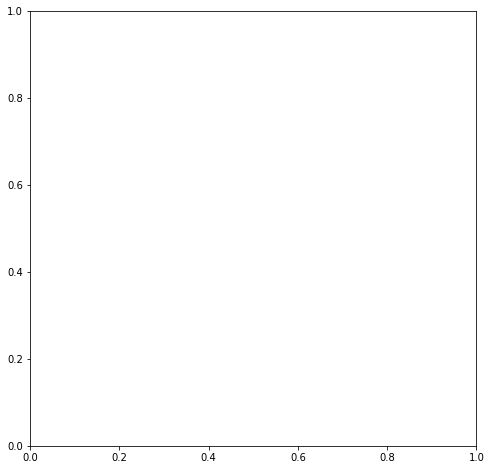

In [11]:
box_layout = widgets.Layout(border='solid 1px rgb(210,210,210)',margin="5px 5px 5px 5px")
box_layout_ = widgets.Layout(margin="10px 0px 10px 0px")
simbox_layout = widgets.Layout(border='solid 1px rgb(210,210,210)',margin="5px 5px 5px 5px",width="100%",height="600px")
upload_layout = widgets.Layout(width="100%")

# Switch between network and local upload
w_upload_type = widgets.ToggleButtons(
    options=['Computer', 'Network'],
    description='Source:',
    disabled=False,
    button_style='info',
    tooltips=['Upload file from local folder', 'Upload from network path'],

)
# Corresponding function defined above this is fine
w_upload_type.observe(on_toogle_filetype, 'value')

w_network_file = widgets.Text(
    value='',
    placeholder='Allowed types: .zip, .txt ; Max filesize = 5mb',
    description='Network file:',
    disabled=True,
    layout=upload_layout
)

w_attribute_file = widgets.Text(
    value='',
    placeholder='Allowed types: .zip, .txt ; Max filesize = 5mb',
    description='Attribute file:',
    disabled=True, 
    layout=upload_layout
)

w_upload_local_nf = fileupload.FileUploadWidget(    
    label="Upload",
)
w_upload_local_nf.observe(_handle_upload_nf, names='data')


w_upload_local_af = fileupload.FileUploadWidget(    
    label="Upload",
)
w_upload_local_af.observe(_handle_upload_af, names='data')


w_upload_network_nf = widgets.Button(
    description='Upload',
    disabled=False,
    button_style='info',
    tooltip='Upload network file',
    icon='upload'
)
w_upload_network_nf.layout.display = 'none'
w_upload_network_nf.on_click(_handle_network_upload_nf)

w_upload_network_af = widgets.Button(
    description='Upload',
    disabled=False,
    button_style='info', 
    tooltip='Upload attribute file',
    icon='upload'
)
w_upload_network_af.layout.display = 'none'
w_upload_network_af.on_click(_handle_network_upload_af)


w_out_network = widgets.Output()

with w_out_network:
    ipydisplay.display(ipydisplay.HTML(input_form + javascript))
    
w_out_attributes = widgets.Output()

with w_out_attributes:
    ipydisplay.display(ipydisplay.HTML(input_form + javascript))

w_run = widgets.Button(
    description='Run',
    disabled=False,
    button_style='success',
    tooltip='Run simulation',
    icon='start'
)
w_import = widgets.Button(
    description='Import',
    disabled=False,
    button_style='warning',
    tooltip='Import',
    icon='start'
)
w_progress=widgets.IntProgress(
    value=0,
    min=0,
    max=10,
    description='Loading:',
    bar_style='info',
    orientation='horizontal'
)
w_progress.layout.visibility ='hidden'
w_upload_typeHBox=widgets.HBox([w_upload_type], layout=box_layout)

w_network_uploadHBox=widgets.HBox([w_network_file, w_upload_local_nf, w_upload_network_nf])

w_network_settings=widgets.HBox([w_out_network])

import_network_box = widgets.VBox([w_network_uploadHBox,w_network_settings],layout=box_layout)

w_attribute_uploadHBox=widgets.HBox([w_attribute_file, w_upload_local_af, w_upload_network_af])

w_attribute_settings_left = widgets.VBox([])

w_attribute_settings=widgets.HBox([ w_attribute_settings_left, w_out_attributes ])
import_attribute_box = widgets.VBox([w_attribute_uploadHBox,w_attribute_settings],layout=box_layout)

w_toolbar=widgets.HBox([w_run, w_progress])
import_box = widgets.VBox([w_upload_typeHBox, import_network_box,import_attribute_box,w_toolbar])

simulation_box = widgets.VBox([w_import,  graphbox],layout=simbox_layout)
simulation_box.layout.display = 'none'

def on_run(b):
    create_greaph()
    w_progress.layout.visibility ='visible'
    import_box.layout.display = 'none'
    simulation_box.layout.display = 'block'
    
def on_import(b):
    simulation_box.layout.display = 'none'
    w_progress.value=0
    w_progress.layout.visibility ='hidden'
    import_box.layout.display = 'block'
        
w_run.on_click(on_run)
w_import.on_click(on_import)
display(simulation_box)
display(import_box)

In [12]:
exportbutton = widgets.Button(
    value=False,
    description='Convert',
    disabled=False,
    button_style='', 
    tooltip='Download animation',
    icon='download'
)

In [13]:
filetyperadios = widgets.RadioButtons(
    options=['Mp4', 'Gif'],
    description='Filetype:',
    disabled=False
)

In [15]:
box = widgets.HBox([filetyperadios, exportbutton])
settings = widgets.HBox([filetyperadios, exportbutton])

In [16]:
tab_nest = widgets.Tab()
tab_nest.children = [box, settings]
tab_nest.set_title(0, 'Export')
tab_nest.set_title(1, 'Settings')
#tab_nest

In [18]:
# http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
ipydisplay.HTML('''
<script>
    code_show=true; 
    function code_toggle() {
         if (code_show){
             $('div.input').hide();
         } else {
             $('div.input').show();
         }
         code_show = !code_show
    } 
    $( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
''')